# Simulations for Understanding the Networked Bounded Confidence Model
_A Network Theory project by Daniel Fisch and Mareike Sehrer (March 2024)_

This code was written as part of the final project for the [BSE](https://bse.eu/study/masters-programs/economics) course Networks I. 

Motivation: 
The DeGroot model is based on the idea that individuals update their opinions by averaging them with the opinions of others in a structural network. On the other hand, the Hegselmann-Krause (HK) model allows agents to interact with all agents whose opinions are within a certain threshold in opinion space. In this project, we propose a hybrid approach, incorporating both network structure and opinion-based influence. We aim to explore possibilities of representing agent-behaviour more realistically to provide a more nuanced understanding of opinion dynamics.

This code helps to understand the dynamics of our proposed model on artificial network structures both graphically and by computing certain metrics. 

## Settting up functions

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from matplotlib.animation import FuncAnimation
from IPython.display import display, Image

sd = 2310 # Seed for generating networks etc.

In [2]:
"""
This function performs one step of the Hegselmann-Krause opinion dynamics model on a given structural graph. 
It updates each node's opinion by considering only the opinions of its connected neighbors within a symmetric confidence bound 'eps'. 
The new opinion is calculated as the average of valid neighbors' opinions, and it ensures that each node's opinion converges toward the opinions of neighbors within the specified confidence bound.

Parameters:
- G: Graph with node attribute 'opinion'
- eps: Confidence bound for considering neighbors' opinions

Returns:
- Updated graph after one step of Hegselmann-Krause opinion dynamics model
"""
def hk_model_step(G, eps):
    # Create a dictionary to store the updated opinions
    updated_opinions = {}

    for node in G.nodes():
        # Get the opinions of the node's neighbors (including itself)
        neighbors = list(G.neighbors(node))
        neighbors.append(node)  # Add the node itself to the neighbors list
        neighbor_opinions = np.array([G.nodes[neighbor]['opinion'] for neighbor in neighbors])

        # Determine neighbors within the confidence bound
        valid_neighbors = neighbor_opinions[(np.abs(neighbor_opinions - G.nodes[node]['opinion']) <= eps)]

        # Calculate new opinion using the average of valid neighbors
        new_opinion = np.mean(valid_neighbors) if len(valid_neighbors) > 0 else G.nodes[node]['opinion']

        # Store the new opinion in the dictionary
        updated_opinions[node] = new_opinion

    # Update the graph with the stored opinions
    nx.set_node_attributes(G, updated_opinions, name='opinion')

    return G

"""
Run the opinion dynamics model until convergence or max_iter

Parameters:
- G: NetworkX graph with node attribute 'opinion'
- alpha: Percentage of similar neighbors each node listens to (0 to 1)
- beta: Discount factor (0 to 1)
- tol: Convergence threshold
- max_iter: Maximum number of iterations

Returns:
- Number of iterations taken for convergence
"""
def hk_model(G, confidence_bound, tol=1e-4, max_iter=1000, history=False):
    iterations = 0
    if history:
        opinions_history = {node: [G.nodes[node]['opinion']] for node in G.nodes()}
        
    while True:
        # Perform one step of the opinion dynamics model
        G_old = G.copy()
        G = hk_model_step(G, confidence_bound)

        if history:
            # Save opinions history
            for node in G.nodes():
                opinions_history[node].append(G.nodes[node]['opinion'])


        # Check for convergence
        opinion_diffs = np.abs(np.array(list(G.nodes(data='opinion'))) - np.array(list(G_old.nodes(data='opinion'))))
        max_opinion_diff = np.max(opinion_diffs[:, 1])

        if max_opinion_diff <= tol:
            break

        iterations += 1

        if iterations >= max_iter:
            print("Warning: Maximum number of iterations reached. Consider increasing max_iter or eps.")
            break
    if history:
        return iterations, opinions_history
    else:
        return iterations
    
"""
Function to plot the opinions within a network G

Parameters:
- G: a networkx graph
- eps: the bounded confidence parameter to highlight 'active' edges
- layout: choice of different layouts (kawai, circular, shell, spring or spectral)

Returns:
- fig
"""
def draw_G(G, eps = -1, layout = 'kawai'):
    # Get the 'opinion' attribute values for all nodes
    opinions = dict(nx.get_node_attributes(G, 'opinion'))
    opinion_values = list(opinions.values())
    
    # Clear previous plot
    plt.clf()
    
    # Set size of figure
    fig, ax = plt.subplots(figsize = (8,5))
    
    # Draw the graph with a scatter plot and colorbar
    if layout == 'kawai':
        pos = nx.kamada_kawai_layout(G)
    elif layout == 'circular':
        pos = nx.circular_layout(G)
    elif layout == 'shell':
        pos = nx.shell_layout(G)
    elif layout == 'spring':
        pos = nx.spring_layout(G, seed = sd)
    elif layout == 'spectral':
        pos = nx.spectral_layout(G)
    else:
        print("Choose as layout either: kawai, circular, shell, spring or spectral")
        return 
    # Draw nodes with colors based on opinions and label them with their opinion
    nodes = nx.draw_networkx_nodes(G, pos, node_color=list(opinions.values()), cmap=plt.cm.coolwarm, node_size=500, vmin=0, vmax=1)
    label_pos = {k: (x, y) for k, (x, y) in pos.items()}
    labels = {key: f'{key}\n{round(value, 2)}' for key, value in opinions.items()}
    nx.draw_networkx_labels(G, pos=label_pos, labels=labels, font_size=8, font_weight='bold',font_color='black', verticalalignment='center', horizontalalignment='center')

    # Color edges of connected nodes in opinion space green (i.e. less than eps seperated)
    for edge in G.edges():
        u, v = edge
        diff_opinion = abs(opinions[u] - opinions[v])
        if diff_opinion <= eps:
            nx.draw_networkx_edges(G, pos, edgelist=[edge], edge_color='green', width=2)
        else:
            nx.draw_networkx_edges(G, pos, edgelist=[edge], edge_color='black', width=1)

    # Add a colorbar
    cbar = plt.colorbar(mappable=cm.ScalarMappable(cmap=plt.cm.coolwarm), norm=plt.Normalize(vmin=0, vmax=1), ax=plt.gca(),label='Opinion')

    return fig

"""
Create a networkx graph with opinion attributes from an edge list and dictionary with initial opinion values
and plots the result

Parameters:
- edge_list
- opinion_values
- eps: confidence bound for plotting
- layout: for plotting

Returns:
initialized network with opininons as attribute
"""
def create_G(edge_list, opinion_values, eps = -1, layout = 'kawai'):
    # Create a directed graph and assign opinion values
    G = nx.Graph(edge_list)
    nx.set_node_attributes(G, opinion_values, name='opinion')
    # Draw the resulting graph
    draw_G(G, eps = eps, layout = layout)
    return G

"""
Function to find iteration when last opinion crossing occured

Parameters:
- history: dictionary with the opinion evolution of each node

Returns:
- iteration at which the order of nodes changed the last time
"""
def last_oc_index(history):
    # Order the keys by the first value of each vector
    ordered_keys = sorted(history.keys(), key=lambda k: history[k][0])
    #print(ordered_keys)
    
    # Initialize the last order change index (oc) to 0
    oc = 0

    # Iterate through the arrays and check for order changes
    for i in range(1, len(history[ordered_keys[0]])):
        current_order = sorted(ordered_keys, key=lambda k: history[k][i])
        #print(current_order)
        
        # Check if the keys are ordered in the same way as the first iteration
        if current_order != ordered_keys:
            # Update oc to the index at which the order last changed
            oc = i
            ordered_keys = current_order

    return oc

"""
A function to calculate the necessary values for prop. 2 in our paper

Parameters:
- G: networkx graoh
- i, j: two nodes to compare
- eps: confidence bound

Returns:
- additional information of i
- additional information of j
- fraction of i's neighbours that are exclusive
- fraction of j's neighbours that are exclusive
- a boolean whether opinion crossing is predicted by prop. 2
"""
def calculate_opinion_metrics(G, i, j, eps):
    # Get opinions of nodes i and j
    opinion_i = G.nodes[i]['opinion']
    opinion_j = G.nodes[j]['opinion']
    
    # Get structural neighbors of nodes i and j
    p_neighbors_i = set(G.neighbors(i))
    p_neighbors_j = set(G.neighbors(j))
    
    # Remove the ones that are too distant in opinion space and add themselves
    neighbors_i = {n for n in p_neighbors_i if abs(G.nodes[n]['opinion'] - opinion_i) <= eps}
    neighbors_j = {n for n in p_neighbors_j if abs(G.nodes[n]['opinion'] - opinion_j) <= eps}
    neighbors_i.add(i)
    neighbors_j.add(j)
    
    # Calculate common and exclusive neighbors
    common_neighbors = neighbors_i.intersection(neighbors_j)
    exclusive_neighbors_i = neighbors_i - common_neighbors
    exclusive_neighbors_j = neighbors_j - common_neighbors
    
    # Calculate average opinion of common neighbors
    C = sum(G.nodes[n]['opinion'] for n in common_neighbors) / len(common_neighbors) if common_neighbors else 0
    
    # Calculate average opinion of exclusive neighbors of i/j
    I = sum(G.nodes[n]['opinion'] for n in exclusive_neighbors_i) / len(exclusive_neighbors_i) if exclusive_neighbors_i else 0
    J = sum(G.nodes[n]['opinion'] for n in exclusive_neighbors_j) / len(exclusive_neighbors_j) if exclusive_neighbors_j else 0

    # Calculate fraction of exclusive neighbors over total neighbors of i/j
    fraction_exclusive_neighbors_i = len(exclusive_neighbors_i) / len(neighbors_i)
    fraction_exclusive_neighbors_j = len(exclusive_neighbors_j) / len(neighbors_j) 
    
    # Calculate if crossing predicted
    if opinion_i > opinion_j:
        crossing = ((I-C) * fraction_exclusive_neighbors_i < (J-C) * fraction_exclusive_neighbors_j)
    elif opinion_i < opinion_j:
        crossing = ((I-C) * fraction_exclusive_neighbors_i > (J-C) * fraction_exclusive_neighbors_j)
    else:
        crossing = None
    return round(I-C, 9), round(J-C,9), fraction_exclusive_neighbors_i, fraction_exclusive_neighbors_j, crossing

"""
A function which calculates for all nodes pairwise a prediction whether they cross

Parameters:
- G: a networkx graph with attribute 'opinions' per node
- eps: the confidence parameter

Returns:
if opinion crossing will occur True, and one pair of nodes for which crossing occurs
if no crossing takes place: False and None
"""
def predict_crossing(G, eps):
    # Get all nodes in the graph
    nodes = list(G.nodes())

    # Iterate through unique pairs of nodes
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            if calculate_opinion_metrics(G, nodes[i], nodes[j], eps)[4]:
                return True, (nodes[i], nodes[j])
    return False, None


## Simulation
This first cell has to be run to initiate the network

<Figure size 432x288 with 0 Axes>

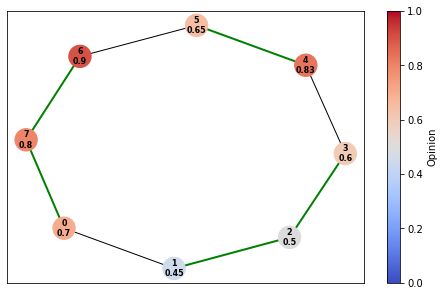

In [6]:
# Define network by edges, opinion values and confidence bound eps
edge_list = [(0, 1), (1, 2), (2,3), (3,4), (4,5), (5,6),(6,7),(7,0)]
opinion_values = {2: 0.5, 3: 0.6, 0: 0.7, 1: 0.45, 4: 5/6, 5:0.65, 6: 0.9, 7:0.8}

eps = 0.2 + 1e-12 # + 1e-12 added to avoid numerical inaccuracies

layout = 'spring'
G = create_G(edge_list, opinion_values, eps = eps, layout= layout)

### a) Plot the evolution of opinions  
The evolution of opinions running the networked bounded confidence model until convergence.

_Remember to re-initialize the graph if it has been changed, e.g. by b)._

In [4]:
# tol = 0: Simulation will run until convergence (up to numerical inaccuracies) 
# max_iter: or until max_iter is reached 
iterations, history = hk_model(G, eps, tol=0, max_iter=1000, history=True)
print("Number of iterations simulated:",iterations)

Number of iterations simulated: 162


Last opinion crossing: 14 - Total iterations 162


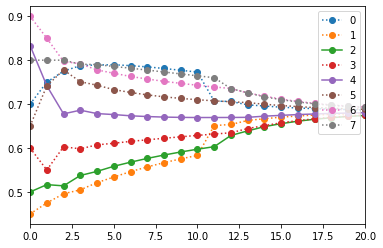

In [5]:
# Highlight certain nodes with solid lines and display only certain iterations
highlight = [2,4]
plt.xlim([0,20])


# Plotting the opinion evolution for each node
for key, h in history.items():
    if key in highlight:
        plt.plot(np.arange(0,len(h),1),h, label = f'{key}', ls = '-', marker ='o')
    else:
        plt.plot(np.arange(0,len(h),1),h, label = f'{key}', ls = ':', marker = 'o')
plt.legend(loc = 1)

print("Last opinion crossing:",last_oc_index(history),"- Total iterations", iterations)
#If they differ by little, numerical inaccuracies might be reason for convergence

### b) Plot the network step-by-step
This code can plot step-by-step how the network evolves and also returns the values needed in prop. 2 for any pair of nodes i, j. It furthermore highlights if an opinion crossing is predicted to take place in the next model step.

_Remember to re-initialize the network if for example the history has been plotted before, since the graph G is then likely to be in stationary state._

2-4: -0.054166667 0.191666667 0.6666666666666666 0.6666666666666666 - upcoming crossing: False
Crossing: True (0, 5)


<Figure size 432x288 with 0 Axes>

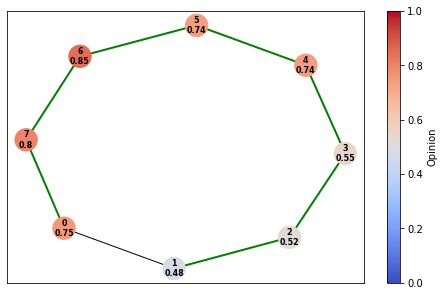

In [7]:
# Calculate metrics for node i and j
i = 2
j = 4

G = hk_model_step(G, eps)
    
# Calculate metrics
I, J, fi, fj, crossing = calculate_opinion_metrics(G, i, j, eps)
print(f"{i}-{j}:", I, J, fi, fj, "- upcoming crossing:", crossing)

#Predict crossing in general
prediction = predict_crossing(G, eps)
print("Crossing:", prediction[0], prediction[1])
plot = draw_G(G, eps, layout = layout)